In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *
from helpers_similarity import *
from helpers_optimization import *
from scipy.optimize import minimize
import time


In [29]:
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0
lambda_reg = 0.1

d_dim = 2
#n_users = 5
#n_movies = 10 #change to n_items !!!
nb_iter = 5
parameters = {}


## Bradley-Terry-Luce (BTL) model

Calculate the difference between each pair of elements in the 2D array X. Then, generate the probability matrix by applying the logistic function $$P(x) = \frac{e^{x}}{1 + e^{x}}$$ element-wise to the difference matrix, where x is the difference between two elements :

In [30]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): # the larger alpha, the flatter and noisier the sigmoid is !! read abt it !!
    
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff


Generate pairwise comparison data $Y_{ijk} = \pm 1$ for each user and item. The output Y is a $3D$ tensor with the shape $(n\_users, n\_items, n\_items)$. Each entry $Y[i,j,k]$ corresponds to whether user i prefers item j over item k. For example, line 0 of Y corresponds to the pairwise comparisons of user 0 with all items: $Y[0,0,:]$ represents whether user 0 prefers item 0 over all other items $(item\_0, item\_1, item\_2, etc..)$, and so on.

In [31]:
def pairwise_comparisons(P):
    
    Y = np.random.binomial(n=1, p=P, size=P.shape) 
    Y = np.where(Y == 0, -1, Y)
    
    return Y

In [32]:
def hinge_loss(x):
    
    return np.maximum(0, 1 - x)**2 

## Minimization of U while V fixed, and V while U fixed

Explain what we're doing here

In [6]:
def sum_loss(U, V, Y):
    n, m, _ = Y.shape
    loss = 0
    for i in range(n):
        for j in range(m):
            for k in range(j):
                if Y[i, j, k] != 0:
                    v = V[:,j] - V[:,k]
                    x = np.dot(U[:,i], v)
                    loss += hinge_loss(Y[i, j, k] * x)
    return loss

In [7]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    
    U=U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg

In [8]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg

In [23]:
def optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    
    start = time.perf_counter()
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)
    U0 = np.random.normal(mu, sigma_u, d_dim*n_users)
    V0 = np.random.normal(mu, sigma_u, d_dim*n_movies)
    preproc_times.append(time.perf_counter() - start)
    
    start = time.perf_counter()
    U_res = minimize(loss_U, U0, args=(Y, V, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    U_times.append(time.perf_counter() - start)

    start = time.perf_counter()
    V_res = minimize(loss_V, V0, args=(Y, U, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    V_times.append(time.perf_counter() - start)

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((d_dim, n_users))
    else :
        print('Minimization failure for U')
        print(U_res.message)
        U_result = U_res.x.reshape((d_dim, n_users))
    diff_norm_U = np.linalg.norm(U - U_result, 'fro')/np.sqrt(n_users) 
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((d_dim, n_movies))
    else :
        print('Minimization failure for V')
        print(V_res.message)
        V_result = V_res.x.reshape((d_dim, n_movies))
    diff_norm_V = np.linalg.norm(V - V_result, 'fro')/np.sqrt(n_movies) 
    
    return diff_norm_U, diff_norm_V


In [24]:
def norm_results(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    avg_U = 0
    avg_V = 0
    n_U = 0
    n_V = 0
    for i in range(nb_iter):
        diff_U, diff_V = optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    avg_U /= n_U
    avg_V /= n_V
    return avg_U, avg_V

In [26]:
N_vals = [5, 10, 20]#, 30, 40, 50]
M_vals = [5, 10, 20]#, 30, 40, 50]
preproc_times = []
U_times = []
V_times = []
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(i,j)
        avg_U, avg_V = norm_results(d_dim, N_vals[i], M_vals[j], preproc_times, U_times, V_times)
        row= [N_vals[i], M_vals[j], avg_U, avg_V]
        data.append(row)

0 0
5.040256900486076 5
4.787775664256873 5
0 1
3.141306854462716 5
4.458691307464411 5
0 2
4.267684486958166 5
4.371333046735981 5
1 0
4.257086061502133 5
5.4060786957296205 5
1 1
4.090013168671029 5
4.887998304996557 5
1 2
4.749999122835945 5
4.4350566738352555 5
2 0
5.555067214338888 5
4.991300536474965 5
2 1


KeyboardInterrupt: 

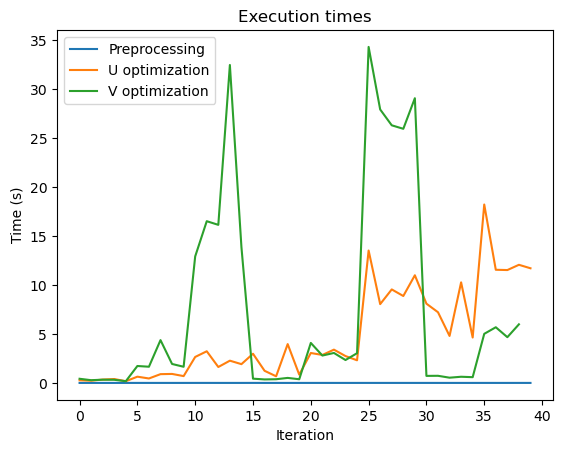

In [27]:
plt.plot( preproc_times, label='Preprocessing')
plt.plot( U_times, label='U optimization')
plt.plot( V_times, label='V optimization')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Execution times')
plt.legend()
plt.show()

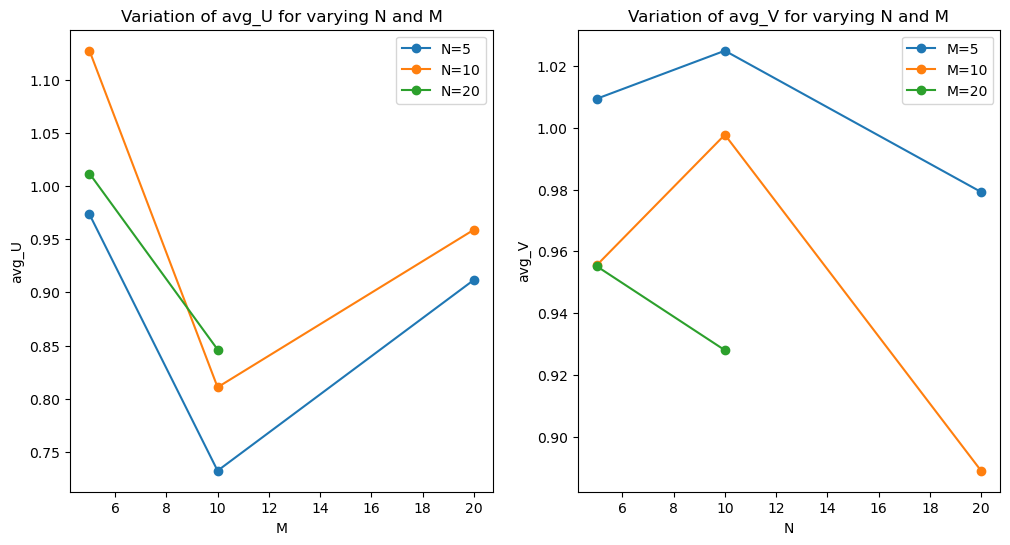

In [ ]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

## Alternating Minimization of U and V

Explain what we're doing here

In [103]:
def update_parameters(n_users, n_movies):
    U = parameters['U_result']
    V = parameters['V_result']
    Y = parameters['Y']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        # V_j = V[:, R[i, :] > 0]
        # U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(d_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        YV = Y[i] @ V.T
        print('Y', Y.shape)
        print(' YV:', YV.shape)
        #print('RV:',RV.shape)
        #print('V.V^T:',np.dot(V,V.T).shape)

        Vinv = np.linalg.inv(np.dot(V,V.T) + lambda_U * np.identity(d_dim))#d_dims
        print('Vinv',Vinv.shape)

        U[:, i] = YV @ Vinv #Vinv @ YV
        print(U[:, i])
    for j in range(n_movies):
        # U_i = U[:, R[:, j] > 0]
        # V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(d_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        RU = Y[:, j] @ U.T
        Uinv = np.linalg.inv(np.dot(U, U.T) + lambda_V * np.identity(d_dim))
        V[:, j] = Uinv @ RU
 
    parameters['U_result'] = U
    parameters['V_result'] = V

In [104]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    Y = parameters['Y']
    UV = np.dot(U_result.T, V_result)
    Y_UV = Y - UV
    
    return -0.5 * (np.sum(np.dot(Y_UV, Y_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


In [105]:
def compare_results(n_users, n_movies):
    U = parameters['U']
    V = parameters['V']
    Y = parameters['Y']

    U_result = parameters['U_result']
    V_result = parameters['V_result']
    Y_result = U_result.T @ V_result
    
    diff_norm_U = np.linalg.norm(U - U_result, 'fro')/np.sqrt(n_users) 
    diff_norm_V = np.linalg.norm(V - V_result, 'fro')/np.sqrt(n_movies) 
 
    diff_norm_Y = frob(Y, Y_result , n_movies*n_users) #orth_procrustes(R, U_result.T @ V_result , n_movies)#
    return diff_norm_Y, diff_norm_U, diff_norm_V


In [106]:
def alt_minimization_U_V(d_dim, n_users, n_movies):
    
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    print(U.shape, X.shape)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P) 
    U0 = np.random.normal(mu, sigma_u, (d_dim, n_users))
    V0 = np.random.normal(mu, sigma_u, (d_dim, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['Y'] = Y
    parameters['U_result'] = U0
    parameters['V_result'] = V0
    parameters['lambda_U'] = sigma**2/sigma_u**2
    parameters['lambda_V'] = sigma**2/sigma_v**2
    log_aps = []


    while True:
        if len(log_aps) > 2:
            if np.abs(log_aps[-1] - log_aps[-2]) < 0.0001:
                break
        update_parameters(n_users, n_movies)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)
    
    diff_norm_Y, diff_norm_U, diff_norm_V = compare_results(n_users, n_movies)
    
    return diff_norm_Y, diff_norm_U, diff_norm_V


In [107]:
def norm_results_altgd(d_dim, n_users, n_movies):
    avg_U = 0
    avg_V = 0
    n_U = 0
    n_V = 0
    for i in range(nb_iter): 
        diff_Y, diff_U, diff_V = alt_minimization_U_V(d_dim, n_users, n_movies)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    avg_U /= n_U
    avg_V /= n_V
    return avg_U, avg_V

In [108]:
N_vals = [5, 10, 20]#, 30, 40, 50]
M_vals = [5, 10, 20]#, 30, 40, 50]
preproc_times = []
U_times = []
V_times = []
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(i,j) 
        avg_U, avg_V = norm_results_altgd(d_dim, N_vals[i], M_vals[j])
        row= [N_vals[i], M_vals[j], avg_U, avg_V]
        data.append(row)

0 0
(2, 5) (5, 5)
Y (5, 5, 5)
 YV: (5, 2)
Vinv (2, 2)


ValueError: could not broadcast input array from shape (5,2) into shape (2,)

In [ ]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()